In [3]:
import torch
device = 'cpu'
import matplotlib.pyplot as plt
import numpy as np
from models.training import create_dataloader
import scipy.io as io


# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 

torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

# design choices 
chosen_problem = 'restricted_TS'
data_noise = 0.
n_different_weights = 1
if n_different_weights == 1:
    print('This choice will generate autonomous dynamics')
else:
    print('This choice generates non-autonomous dynamics, letting the weights depend on time')

possible_problem = {'moons':'moons', 'ToggleSwitch':'TS', 'repressilator':'repr', 'restricted_TS': 'restrictedTS'} 
# this choices determine the data set that we build and subsequent choices on the construction of the neural ODE 
# - in particular, it determines the dimensions 
problem = possible_problem[chosen_problem]

plotlim = [0, 5]

56
This choice will generate autonomous dynamics


In [4]:
ind = 0
m1vec = []
m2vec = []
lossvec = []
var1vec = []
var2vec = []
for sz in range(2,3):

    m1vectemp = []
    m2vectemp = []
    lossvectemp = []
    Xtempvec = []
    W1vec = []

    for k in range(0,50):
        
        ind = ind + 1
        seed = ind

        dataloader, dataloader_viz, X_train = create_dataloader(problem, batch_size = sz, noise = data_noise, 
                                                    plotlim = plotlim, random_state = seed, label = 'vector')
        
        print(k)
        print(X_train.detach().numpy())

        #Import of the model dynamics that describe the neural ODE
        #The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
        from models.neural_odes import NeuralODE

        #T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
        T, num_steps = 1, n_different_weights
        bound = 0.
        fp = False
        cross_entropy = False
        turnpike = False

        # choice of model: what nonlinearity is used and if the nonlinearity is applied before (inside) or after (outside) the linear weights
        # another choice is bottleneck, but I don't understand it
        # non_linearity = 'tanh' # OR 'relu' 'sigmoid' 'leakyrelu' 'tanh_prime'
        # architecture = 'inside' 'outside'
        non_linearity = 'tanh'
        architecture = 'restricted'
        architectures = {'inside': -1, 'outside': 0, 'bottleneck': 1, 'restricted': 2}
        # number of optimization runs in which the dataset is used for gradient decent
        num_epochs = 50
        if problem == 'moons' or problem == 'TS' or problem == "restrictedTS":
            hidden_dim, data_dim = 2, 2 
        else:
            hidden_dim, data_dim = 3, 3 
        augment_dim = 0

        # resets the seed - allows for coherent runs in the gradient descent as well
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        anode = NeuralODE(device, data_dim, hidden_dim, output_dim=data_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                            architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
        optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-1)

        from models.training import doublebackTrainer

        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                                bound=bound, fixed_projector=fp, verbose = False, eps_comp = 0.2)

        trainer_anode.train(dataloader, 200)

        W1 = anode.flow.dynamics.fc1_time[0].weight
        W1 = W1.detach().numpy()
        m1 = abs(W1[0][1]-W1[1][0])
        m2 = abs(W1[0][0])+abs(W1[1][1])

        lv = trainer_anode.histories["loss_history"]
        l = lv[-1]

        m1vectemp.append(m1)
        m2vectemp.append(m2)
        lossvectemp.append(l)
        Xtempvec.append(X_train.detach().numpy())
        W1vec.append(W1)
    
    mdic = {"X":Xtempvec,"l":lossvectemp,"symm":m1vectemp,"offdiag":m2vectemp,"W1":W1vec}
    io.savemat("inout_inside_n"+str(sz)+".mat",mdic)
    m1vec.append(np.mean(m1vectemp))
    m2vec.append(np.mean(m2vectemp))
    lossvec.append(np.mean(lossvectemp))
    var1vec.append(np.var(m1vectemp))
    var2vec.append(np.var(m2vectemp))

No change  applied to TS or repr data
0
[[4.765574  2.803489 ]
 [1.7676971 4.7275352]]
No change  applied to TS or repr data
1
[[3.788158  1.3965545]
 [2.0153463 3.6734223]]
No change  applied to TS or repr data
2
[[3.0734754 1.9050643]
 [3.1855717 2.3723054]]
No change  applied to TS or repr data
3
[[0.0213176  0.5278468 ]
 [1.4292123  0.13477415]]
No change  applied to TS or repr data
4
[[2.798193   2.7954621 ]
 [0.45728415 1.0500159 ]]
No change  applied to TS or repr data
5
[[4.1512594  0.63055456]
 [4.5373483  4.099635  ]]
No change  applied to TS or repr data
6
[[2.8609877 2.7693775]
 [4.9341497 3.040148 ]]
No change  applied to TS or repr data
7
[[2.6746128  0.99401593]
 [3.2960584  3.2844515 ]]
No change  applied to TS or repr data
8
[[2.9896364 4.2264805]
 [4.7320514 1.4826515]]
No change  applied to TS or repr data
9
[[3.2789226 1.5101135]
 [2.3994823 3.886868 ]]
No change  applied to TS or repr data
10
[[2.2904232 2.4142828]
 [1.5624917 3.0751083]]
No change  applied to TS o

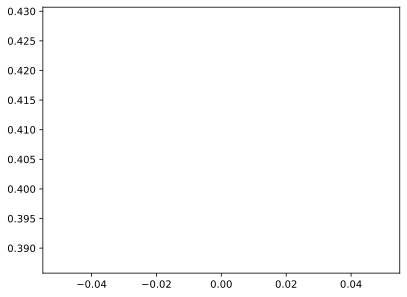

In [5]:
plt.plot(m1vec)

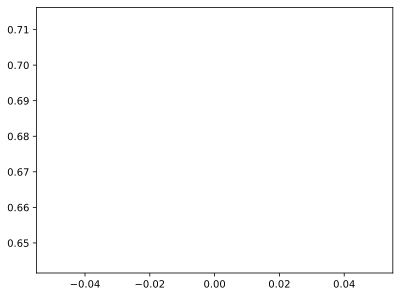

In [6]:
plt.plot(m2vec)

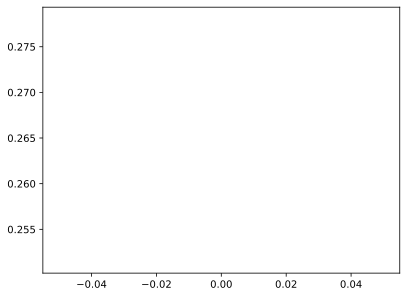

In [7]:
plt.plot(var1vec)

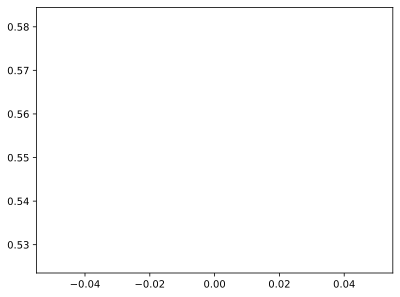

In [8]:
plt.plot(var2vec)

In [9]:
print(lv)

[6.697253227233887, 0.5277709148824214, 0.47183008790016173, 0.40010902285575867, 0.18586941063404083, 0.13465863093733788, 0.11555669829249382, 0.11582266464829445, 0.11173605695366859, 0.11093825697898865, 0.1106386661529541, 0.11025407761335373, 0.10992926210165024, 0.10959985852241516, 0.10920913070440293, 0.10873595625162125, 0.1081463448703289, 0.10736626759171486, 0.10629391595721245, 0.1047006905078888]
